# data prepro

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms.functional import rotate, InterpolationMode, to_tensor
import numpy as np
from PIL import Image
import os

torch.manual_seed(0)
np.random.seed(0)

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,  download=True)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_idx = np.random.choice(len(mnist_train), size=5000, replace=False)
test_idx  = np.random.choice(len(mnist_test),  size=5000, replace=False)

class RotatedDigits(Dataset):
    def __init__(self, base_ds, idxs):
        self.base   = base_ds
        self.idxs   = idxs
        self.angles = np.random.uniform(-45, 45, size=len(idxs)).astype(np.float32)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, i):
        img, _ = self.base[self.idxs[i]]
        angle   = float(self.angles[i])
        img_r = rotate(img, angle,
                       interpolation=InterpolationMode.BILINEAR,
                       fill=0)
        x = to_tensor(img_r) 
        return x, torch.tensor(angle)

# build datasets
train_ds = RotatedDigits(mnist_train, train_idx)
test_ds  = RotatedDigits(mnist_test,  test_idx)

batch_size = 128
train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = val_loader  

print(f"Train: {len(train_ds)} samples  Val/Test: {len(test_ds)} samples")

output_dir_train = './use_data/train'
output_dir_test = './use_data/test'

print("Saving training images...")
for i, (img_tensor, angle) in enumerate(train_ds):
    img_pil = Image.fromarray(img_tensor.squeeze(0).mul(255).byte().numpy())
    img_pil.save(os.path.join(output_dir_train, f'train_{i:04d}_angle_{angle.item():.2f}.png'))
print(f"Saved {len(train_ds)} training images to {output_dir_train}")

print("Saving testing images...")
for i, (img_tensor, angle) in enumerate(test_ds):
    img_pil = Image.fromarray(img_tensor.squeeze(0).mul(255).byte().numpy())
    img_pil.save(os.path.join(output_dir_test, f'test_{i:04d}_angle_{angle.item():.2f}.png'))
print(f"Saved {len(test_ds)} testing images to {output_dir_test}")


Train: 5000 samples  Val/Test: 5000 samples
Saving training images...
Saved 5000 training images to ./use_data/train
Saving testing images...
Saved 5000 testing images to ./use_data/test


# matlab

✔ Best at epoch 1: Val RMSE=46.8783
✔ Best at epoch 2: Val RMSE=13.8405
✔ Best at epoch 4: Val RMSE=13.6918
✔ Best at epoch 5: Val RMSE=11.7929
✔ Best at epoch 8: Val RMSE=11.5373
✔ Best at epoch 14: Val RMSE=11.2776
✔ Best at epoch 15: Val RMSE=11.2698
✔ Best at epoch 18: Val RMSE=11.0847
✔ Best at epoch 21: Val RMSE=10.6083
✔ Best at epoch 23: Val RMSE=10.6043
✔ Best at epoch 24: Val RMSE=10.5584
🏆 Best validation RMSE=10.5584 at epoch 24


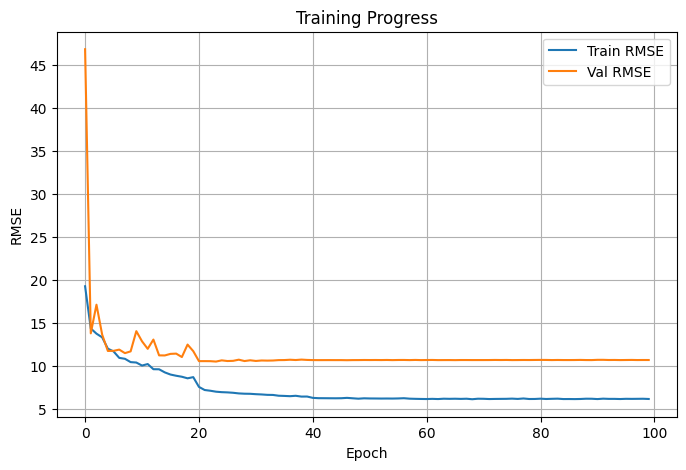

In [4]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = EnhancedCNNRegressor().to(device)


criterion = nn.MSELoss()                 
def rmse(total_loss, n):                
    return math.sqrt(total_loss / n)

optimizer = optim.SGD(model.parameters(),
                      lr=1e-3,
                      momentum=0.9)      
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=20,   
                                      gamma=0.1)      

num_epochs = 100
train_rmse_history = []
val_rmse_history   = []
best_val_rmse = float('inf')
best_epoch    = -1

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_mse = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_train_mse += loss.item() * xb.size(0)

    model.eval()
    total_val_mse = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            total_val_mse += criterion(model(xb), yb).item() * xb.size(0)

    train_rmse = rmse(total_train_mse, len(train_loader.dataset))
    val_rmse   = rmse(total_val_mse,   len(val_loader.dataset))
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✔ Best at epoch {epoch}: Val RMSE={best_val_rmse:.4f}")

    scheduler.step()

print(f"🏆 Best validation RMSE={best_val_rmse:.4f} at epoch {best_epoch}")

plt.figure(figsize=(8,5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history,   label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()